In [1]:
import sys
sys.path.append('/home/peidli/projects/pertpy')
import pertpy as pt

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy

In [3]:
import jax.numpy as jnp
from jax import random

def generate_toy_data(n_guides=3, n_cells_per_group=50):
    dats = []
    for i in range(n_guides):
        # Simulate positive and negative population for each guide
        key = random.PRNGKey(i)
        key1, key2 = random.split(key)

        # Negative first
        poisson_data = random.poisson(key=key1, lam=0.1, shape=(n_cells_per_group * i,)).astype(jnp.float32)

        # Positive
        gaussian_data = random.normal(key=key2, shape=(n_cells_per_group,)) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)

        # Negative second
        poisson_data_ = random.poisson(key=key1, lam=0.1, shape=(n_cells_per_group * (n_guides - i - 1),)).astype(
            jnp.float32
        )

        # The count vector for one guide is the concatenation of the negative and positive populations
        guide_data = jnp.hstack([poisson_data, gaussian_data, poisson_data_])
        dats.append(guide_data)
    guide_counts = np.array(jnp.vstack(dats)).T

    # Combine Poisson and Gaussian data into one dataset
    adata = sc.AnnData(
        guide_counts,
        obs=pd.DataFrame(index=[f"cell{i+1}" for i in range(guide_counts.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i+1}" for i in range(guide_counts.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide" + str(i + 1) for i in range(n_guides) for _ in range(n_cells_per_group)]
    return adata

In [4]:
adata = generate_toy_data(n_guides=3, n_cells_per_group=50)

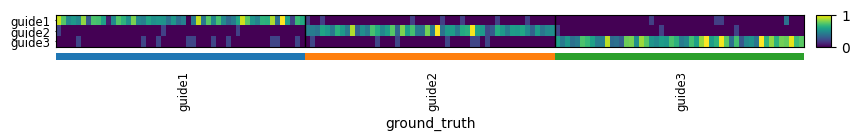

In [5]:
sc.pl.heatmap(
    adata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=adata.var_names, swap_axes=True
)

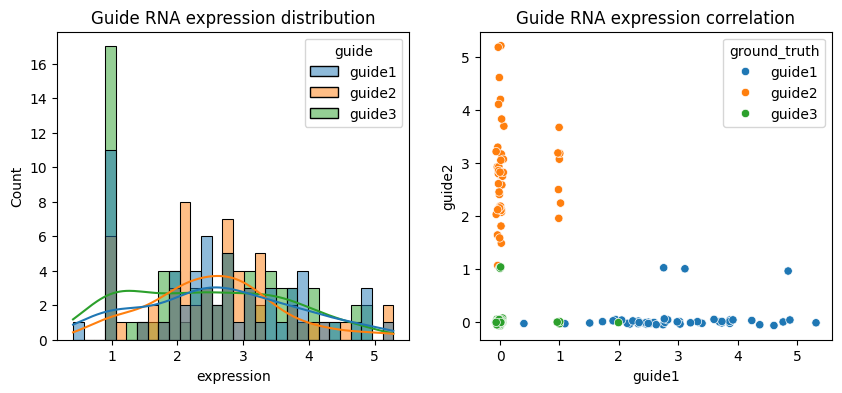

In [6]:
df = adata.to_df().stack().reset_index().rename(columns={"level_0": "cell", "level_1": "guide", 0: "expression"})
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
df = df[df.expression > 0]
sns.histplot(df, x="expression", hue="guide", bins=30, kde=True, ax=axs[0])
axs[0].set_title("Guide RNA expression distribution")
df = adata.to_df()
df = np.random.normal(0, 0.03, df.shape) + df  # Add jitter
sns.scatterplot(data=df, x="guide1", y="guide2", hue=adata.obs["ground_truth"], ax=axs[1])
axs[1].set_title("Guide RNA expression correlation")
plt.show()

In [7]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(adata, assigned_guides_key="assigned_guide_mixture_model")

AttributeError: 'GuideAssignment' object has no attribute 'assign_mixture_model'

In [ ]:
import numpyro.distributions as dist
# plot probability distributions of model
n_guides = len(adata.var_names)
guides = adata.var_names
fig, axs = plt.subplots(1, n_guides, figsize=(7 * n_guides, 5))
for ax, guide in zip(axs, guides):
    # plot gaussian distribution
    x = np.linspace(0, 6, 100)
    y = dist.Normal(
        adata.var.loc[guide, "gaussian_mean"],
        adata.var.loc[guide, "gaussian_std"],
    ).log_prob(x)
    ax.plot(x, np.exp(y), label="Normal\n(positive population)")
    # plot poisson distribution
    x = np.linspace(0, 5, 100)
    y = dist.Poisson(adata.var.loc[guide, "poisson_rate"]).log_prob(x)
    ax.plot(x, np.exp(y), label="Poisson\n(negative population)")
    
    # Plot ground truth empirical distribution
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth == guide, guide].X),
        color="cyan",
        label="Ground True Positive",
        ax=ax,
        clip=(0, 6),
    )
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth != guide, guide].X),
        color="red",
        label="Ground True Negative",
        ax=ax,
        clip=(0, 6),
    )

    ax.set_xlabel(f"{guide} counts")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_title(f"Inferred distributions of guide counts for {guide}")

plt.show()

In [ ]:
# evaluate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"])
f1 = f1_score(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"], average="weighted")

labels = np.unique(adata.obs["assigned_guide_mixture_model"])
cm = confusion_matrix(adata.obs["ground_truth"], adata.obs["assigned_guide_mixture_model"], labels=labels)
cm = pd.DataFrame(cm, index=labels, columns=labels).loc[adata.obs["ground_truth"].unique()]
ax = sns.heatmap(cm.T, annot=True, fmt="d", cmap="viridis")
ax.set_ylabel("Predicted")
ax.set_xlabel("Ground Truth")
plt.title(f"Confusion matrix\nAccuracy: {np.round(accuracy, 2)}, F1 score: {np.round(f1, 2)}")
plt.show()

In [ ]:
ga.assign_by_threshold(adata, assignment_threshold=1, output_layer="assigned_guide_threshold")
ga.assign_to_max_guide(adata, assignment_threshold=1, output_key="assigned_guide_max")

# Convert the threshold assignment to a string
matrix = adata.layers["assigned_guide_threshold"].todense()
result = []
for row in np.asarray(matrix):  # Convert to a standard 2D array
    indices = [f"guide{i+1}" for i, val in enumerate(row) if val == 1]
    result.append("+".join(indices) if indices else None)
adata.obs["assigned_guide_threshold"] = result
adata.obs.loc[adata.obs["assigned_guide_threshold"].isna(), "assigned_guide_threshold"] = "Negative"

In [ ]:
evaluation = {}
for key in ['assigned_guide_mixture_model', 'assigned_guide_max', 'assigned_guide_threshold']:
    evaluation[key] = (accuracy_score(adata.obs["ground_truth"], adata.obs[key]), f1_score(adata.obs["ground_truth"], adata.obs[key], average="weighted"))
df = pd.DataFrame(evaluation, index=["Accuracy", "F1 score"]).T
df.index = df.index.str.replace("assigned_guide_", "")
sns.heatmap(df, annot=True, cmap="viridis", annot_kws={"size": 15}, cbar_kws={"label": "Scores"})
plt.title("Accuracy and F1 score of assignment methods")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(4*3, 4), sharey=True)
for ax, key in zip(axs, ['assigned_guide_mixture_model', 'assigned_guide_max', 'assigned_guide_threshold']):
    labels = np.unique(adata.obs[key])
    cm = confusion_matrix(adata.obs["ground_truth"], adata.obs[key], labels=labels)
    cm = pd.DataFrame(cm, index=labels, columns=labels).loc[adata.obs["ground_truth"].unique()]
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax)
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Ground Truth")
    ax.set_title(f"Confusion matrix for\n{key}")
    # rotate y labels
    plt.setp(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def generate_toy_data_doubles(n_guides=2, n_cells_per_group=50):
    dats = []
    for i in range(n_guides):
        # Simulate positive and negative population for each guide
        key = random.PRNGKey(i)
        key1, key2, key3 = random.split(key, num=3)

        # Negative first
        poisson_data = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * i,)).astype(jnp.float32)
        if i == 1:  # Add a double positive population for the second guide
            poisson_data = random.normal(key3, shape=(n_cells_per_group,)) * 1.0 + 3
            poisson_data = poisson_data.clip(0.0, None)

        # Positive
        gaussian_data = random.normal(key2, shape=(n_cells_per_group,)) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)

        # Negative second
        poisson_data_ = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * (n_guides - i - 1),)).astype(
            jnp.float32
        )

        # The count vector for one guide is the concatenation of the negative and positive populations
        guide_data = jnp.hstack([poisson_data, gaussian_data, poisson_data_])
        dats.append(guide_data)
    guide_counts = np.array(jnp.vstack(dats)).T

    # Combine Poisson and Gaussian data into one dataset
    adata = sc.AnnData(
        guide_counts,
        obs=pd.DataFrame(index=[f"cell{i+1}" for i in range(guide_counts.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i+1}" for i in range(guide_counts.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide" + str(i + 1) for i in range(n_guides) for _ in range(n_cells_per_group)]
    col = adata.obs["ground_truth"].copy()
    col.iloc[:n_cells_per_group] = "guide1+guide2"
    adata.obs["ground_truth"] = col
    return adata

In [ ]:
bdata = generate_toy_data_doubles(n_guides=3, n_cells_per_group=50)
sc.pl.heatmap(
    bdata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=adata.var_names, swap_axes=True
)